# GD04 Sementic Segmentation  
## Objective
1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?  
- KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.
2. U-Net++ 모델이 성공적으로 구현되었는가?  
- U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.
3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?  
- U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

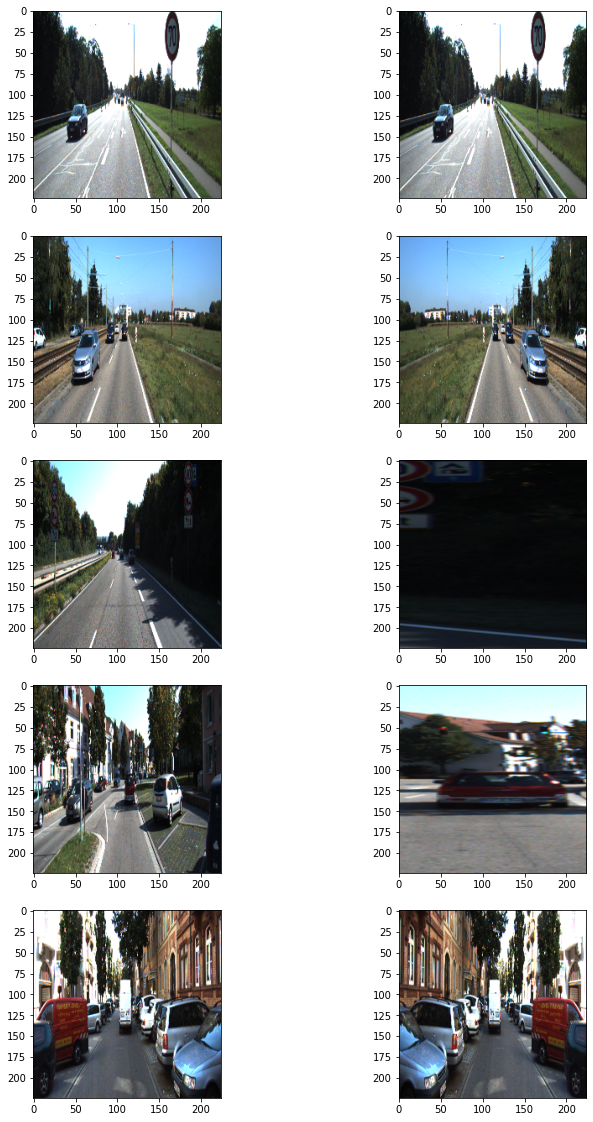

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터셋를 구성합니다

In [40]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
            dir_path,
            batch_size=8,
            img_size=(224, 224, 3),
            output_size=(224, 224),
            is_train=True,
            augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs

    def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        return self.indexes

In [41]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### U-Net 구현  
세그멘테이션 모델 중 하나인 U-Net을 구현하여 사용합니다  
입력 이미지의 크기는 데이터셋에 맞추어 만듭니다  
Conv2D, Conv2DTranspose, Maxpooling2D, Concatenate를 사용합니다  
Dropout등의 레이어는 학습 추이 확인 후 필요 시 추가로 구현합니다  
패딩 여부는 학습 추이 후 필요 시 제외합니다  

In [6]:
def build_model_Unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

### Train 부분

## 테스트 결과 확인  
추론 결과를 확인할 수 있는 함수를 구현합니다

### 결과 시각화
추론 결과를 입력 이미지 위에 겹쳐서 볼 수 있게 overlay 하는 함수를 구현합니다  

In [7]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

In [8]:
# get_output(
#      model, 
#      test_preproc,
#      image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
#      output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
#  )

### IoU 계산
추론 결과과 ground truth의 IoU score를 계산하여, 정량적으로 모델 성능을 측정합니다

In [9]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
#    print('IoU : %f' % iou_score )
    return iou_score

In [10]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [11]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
# i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
# output, prediction, target = get_output(
#      model, 
#      test_preproc,
#      image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
#      output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
#      label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
#  )

# calculate_iou_score(target, prediction)

### U++ 구현
![nn](unetplusfig1.PNG)
UNet의 발달된 버전은 다음과 같이 소개되어 있습니다  
UNet<sup>e</sup>  Ensemble 구조, 
점선 : 스킵커넥션  
실선 : 업샘플링  
x<sub>ij</sub> = conv after activation x<sub>i-1,j</sub> if j = 0, else 


In [12]:
def build_model_Unet_plus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    #Order > ( [(0,0) > (1,0) > (0,1)] , [(2,0) > (1,1) > (0,2)] , [(3,0) > (2,1), (1,2), (0,3)], []
    
    #Contracting Path
    conv00 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv00 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv00)
    pool00 = MaxPooling2D(pool_size=(2, 2))(conv00)      #layer 0,0
    
    # 2nd floor 1st node
    conv10 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool00)
    conv10 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv10)
    pool10 = MaxPooling2D(pool_size=(2, 2))(conv10)
    
    ### New Architecture for UNet+
    up10 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv10) #x10 to x01
    merge01 = concatenate([conv00,up10], axis = 3)
    
    ### 3rd floor 1st node
    
    conv20 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool10)
    conv20 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv20)
    pool20 = MaxPooling2D(pool_size=(2, 2))(conv20)

    ### New Architecture for UNet+    
    up20 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv20) #x20 to x11
    merge11 = concatenate([conv10, up20], axis = 3) #x11
    
    up11 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(merge11) #x11 to x02
    merge02 = concatenate([merge01,up11], axis = 3) #x02
    
    ### 4th floor 1st node
    
    conv30 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool20)
    conv30 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv30)
    drop30 = Dropout(0.5)(conv30)
    pool30 = MaxPooling2D(pool_size=(2, 2))(drop30)
    
    up30 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop30) #x30 to x21
    merge21 = concatenate([conv20, up30], axis = 3) #x11
    
    up21 =  Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(merge21) #x21 to x12
    merge12 = concatenate([merge11, up21], axis = 3)
    
    up12 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(merge12) #x12 to x03
    merge03 = concatenate([merge02,up12], axis = 3) #x03
    
    ### 5th floor - bottom - turning point
    
    conv40 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool30)  
    conv40 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv40)

    #Expanding Path
    drop40 = Dropout(0.5)(conv40)
    up31 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop40)
    merge31 = concatenate([drop30, up31], axis = 3)
    
    ### expanding to 4th floor
    conv31 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge31)
    conv31 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv31)
    up22 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv31)
    merge22 = concatenate([merge21,up22], axis = 3)
    
    ### expanding to 3rd floor
    conv22 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge22)
    conv22 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv22)
    up13 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv22)
    merge13 = concatenate([merge12, up13], axis = 3)
    
    ### expanding to 2nd floor
    conv13 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge13)
    conv13 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv13)
    up04 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv13)
    merge04 = concatenate([merge03,up04], axis = 3)

    ### expanding to 1st floor
    conv04 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge04)
    conv04 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv04)  
    conv04 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv04)     

    ### making result
    conv_fin = Conv2D(1, 1, activation='sigmoid')(conv04)

    model = Model(inputs = inputs, outputs = conv_fin)
    return model

In [13]:
model_unet_plus = build_model_Unet_plus()

In [14]:
model_unet_plus.summary()

#모델 섬머리 크로스체크

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [15]:
def build_model_Unet_plus_plus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    #Order > ( [(0,0) > (1,0) > (0,1)] , [(2,0) > (1,1) > (0,2)] , [(3,0) > (2,1), (1,2), (0,3)], [(4,0) ~ (0,4)]
    
    #Contracting Path
    conv00 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv00 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv00)
    pool00 = MaxPooling2D(pool_size=(2, 2))(conv00)      #layer 0,0
    
    # 2nd floor 1st node
    conv10 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool00)
    conv10 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv10)
    pool10 = MaxPooling2D(pool_size=(2, 2))(conv10)
    
    up10 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv10) #x10 to x01
    merge01 = concatenate([conv00,up10], axis = 3)
    
    ### 3rd floor 1st node    
    conv20 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool10)
    conv20 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv20)
    pool20 = MaxPooling2D(pool_size=(2, 2))(conv20)

    up20 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv20) #x20 to x11
    merge11 = concatenate([conv10, up20], axis = 3) #x11
    
    up11 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(merge11) #x11 to x02
    merge02 = concatenate([conv00, merge01, up11], axis = 3) #x02   #different point from UNet+
    
    ### 4th floor 1st node
    
    conv30 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool20)
    conv30 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv30)
    drop30 = Dropout(0.5)(conv30)
    pool30 = MaxPooling2D(pool_size=(2, 2))(drop30)
    
    up30 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop30) #x30 to x21
    merge21 = concatenate([conv20, up30], axis = 3) #x11
    
    up21 =  Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(merge21) #x21 to x12
    merge12 = concatenate([conv10, merge11, up21], axis = 3)     #different point from UNet+
    
    up12 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(merge12) #x12 to x03
    merge03 = concatenate([conv00, merge01, merge02,up12], axis = 3) #x03     #different point from UNet+
    
    ### 5th floor - bottom - turning point
    
    conv40 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool30)  
    conv40 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv40)

    #Expanding Path
    drop40 = Dropout(0.5)(conv40)
    up31 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop40)
    merge31 = concatenate([drop30, up31], axis = 3)
    
    ### expanding to 4th floor
    conv31 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge31)
    conv31 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv31)
    up22 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv31)
    merge22 = concatenate([conv20, merge21, up22], axis = 3)    #different point from UNet+
    
    ### expanding to 3rd floor
    conv22 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge22)
    conv22 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv22)
    up13 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv22)
    merge13 = concatenate([conv10, merge11, merge12, up13], axis = 3)   #different point from UNet+
    
    ### expanding to 2nd floor
    conv13 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge13)
    conv13 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv13)
    up04 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv13)
    merge04 = concatenate([conv00, merge01, merge02, merge03, up04], axis = 3)   #different point from UNet+

    ### expanding to 1st floor
    conv04 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge04)
    conv04 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv04)  
    conv04 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv04)     

    ### making result
    conv_fin = Conv2D(1, 1, activation='sigmoid')(conv04)

    model = Model(inputs = inputs, outputs = conv_fin)
    return model

In [16]:
model_unet_pp = build_model_Unet_plus_plus()

In [17]:
model_unet_pp.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_21[0][0]                  
____________________________________________________________________________________________

UNet+ 와 UNET++를 구현했습니다  

### Custom loss function  
https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/helper_functions.py#L37

In [31]:
from keras import backend     #다양한 연산을 위한 util 제공

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = backend.flatten(y_true)
    y_pred_f = backend.flatten(y_pred)
    intersection = backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (backend.sum(y_true_f) + backend.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

#model.compile(optimizer="Adam", loss=dice_coef_loss, metrics=["binary_crossentropy", mean_iou, dice_coef])
# dice function들은 기존 저자의 구현물을 사용하겠습니다

In [19]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
model_path_plus = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus.h5'
model_path_pp = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_pp.h5'

In [44]:
EPOCH = 30   #원안에는 100번
LEARNING_RATE = 1e-4

num_classes = 8

In [25]:
#테스트로 오류없는지 확인
model_unet = build_model_Unet()
model_unet_p = build_model_Unet_plus()
model_unet_pp = build_model_Unet_plus_plus()

In [22]:
model_unet.compile(optimizer = Adam(LEARNING_RATE), loss = 'binary_crossentropy')
history_unet = model_unet.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=1,
 )

#model_unet.save(model_path)  #학습한 모델을 저장해 주세요.

11/11 [==============================] - 28s 800ms/step - loss: 0.6942 - val_loss: 0.6915


In [34]:
del model_unet
del history_unet

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/compat/v1/metrics/mean_iou

In [32]:
model_unet_p.compile(optimizer = Adam(LEARNING_RATE), loss=dice_coef_loss)
history_unet_p = model_unet_p.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=1,
 )


11/11 [==============================] - 25s 1s/step - loss: 0.6994 - val_loss: 0.6781


In [35]:
del model_unet_p
del history_unet_p

In [43]:
model_unet_pp.compile(optimizer = Adam(LEARNING_RATE), loss=dice_coef_loss)
history_unet_pp = model_unet_pp.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=1,
 )


22/22 [==============================] - 47s 1s/step - loss: 0.6195 - val_loss: 0.5656


In [42]:
del model_unet_pp
del history_unet_pp

세 모델이 모두 돌아감을 확인했습니다  
이제 학습을 진행하겠습니다  

In [45]:
def history_to_csv(history, filename):
    hist_df = pd.DataFrame(history.history) 
    with open(filename, mode='w') as f:
        hist_df.to_csv(f)

In [46]:
history_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/train_unet.csv'
history_path_plus = os.getenv('HOME')+'/aiffel/semantic_segmentation/train_unet_plus.csv'
history_path_pp = os.getenv('HOME')+'/aiffel/semantic_segmentation/train_unet_pp.csv'

## 학습

In [48]:
model_unet = build_model_Unet()

In [ ]:
model_unet.compile(optimizer = Adam(LEARNING_RATE), loss = 'binary_crossentropy')
history_unet = model_unet.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=EPOCH,
 )

model_unet.save(model_path)
history_to_csv(history_unet, history_path)

Epoch 1/30
22/22 [==============================] - 14s 443ms/step - loss: 0.6770 - val_loss: 0.6597
Epoch 2/30
22/22 [==============================] - 10s 423ms/step - loss: 0.6092 - val_loss: 0.6113
Epoch 3/30
22/22 [==============================] - 10s 423ms/step - loss: 0.5691 - val_loss: 0.5651
Epoch 4/30
22/22 [==============================] - 9s 419ms/step - loss: 0.5231 - val_loss: 0.5073
Epoch 5/30
22/22 [==============================] - 10s 429ms/step - loss: 0.4458 - val_loss: 0.3152
Epoch 6/30
22/22 [==============================] - 9s 413ms/step - loss: 0.2878 - val_loss: 0.2862
Epoch 7/30
18/22 [=======================>......] - ETA: 1s - loss: 0.2755